# 신한카드 요식업과 SKT 유동인구 분석

In [11]:
!pip install dbfread
!pip install haversine
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dbfread import DBF
from haversine import haversine
from tqdm.notebook import tqdm
%matplotlib inline
import platform
import pickle
import re
from math import ceil
platform.system()
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'

## 신한카드

In [12]:
df_seoul = pd.read_pickle('seoul_신한카드.pkl')
df_dong_code = pd.read_excel('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/02_혁신아이디어분야_카드소비데이터(신한카드)_데이터정의서.xlsx',
                            sheet_name='(참고) 행정동코드', skiprows=1)
df_upjong_code = pd.read_excel('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/02_혁신아이디어분야_카드소비데이터(신한카드)_데이터정의서.xlsx',
                            sheet_name='(참고) 업종코드', skiprows=1)
df_upjong_code = df_upjong_code[['업종코드 (32개 분류)']]
df_upjong_code.dropna(inplace=True)

In [13]:
df_seoul

,기준일자,행정동코드,업종코드,성별코드,나이코드,이용건수,이용금액,건별 이용금액
구코드,,,,,,,,
140,20190201,520,10,F,20,14,1038,74.1
140,20190201,520,10,F,25,59,4635,78.6
140,20190201,520,10,F,30,41,3046,74.3
140,20190201,520,10,F,35,59,5995,101.6
140,20190201,520,10,F,40,45,5172,114.9
...,...,...,...,...,...,...,...,...
350,20200531,720,81,M,45,19,127,6.7
350,20200531,720,81,M,50,33,211,6.4
350,20200531,720,81,M,55,9,61,6.8


In [14]:
pd.options.display.float_format = '{:.1f}'.format

In [15]:
df_dong_code = df_dong_code[:34]

In [16]:
import re
upjong_dic={}
gu_dic={}
gu_dong_dic={}
for i, j in zip(df_dong_code['구코드'], df_dong_code['구명']):
    gu_dic[i]=j
for i, j, x, y in zip(df_dong_code['구코드'], df_dong_code['구명'], df_dong_code['행정동코드'], df_dong_code['행정동명']):
    gu_dong_dic[(i,x)]=y
for i in df_upjong_code.values:
    key = re.findall('\((.*)\)',i[0])[0]
    val = re.findall('(.*)\(',i[0])[0]
    upjong_dic[key]=val

In [17]:
#type 바꿔주기
df_seoul['기준일자'] = df_seoul['기준일자'].astype(str)
df_seoul['기준일자'] = pd.to_datetime(df_seoul['기준일자'])
df_seoul['업종코드'] = df_seoul['업종코드'].astype(str)

#시구, 동, 업종코드 mapping
df_seoul['시_구'] = df_seoul.index.map(gu_dic)
df_seoul['행정동'] = [gu_dong_dic[(i,x)] for i,x in zip(df_seoul.index, df_seoul['행정동코드'])]
df_seoul['업종'] = df_seoul['업종코드'].map(upjong_dic)

In [18]:
df_seoul['Year'] = df_seoul['기준일자'].dt.year
df_seoul['Month'] = df_seoul['기준일자'].dt.month

In [19]:
#20대만보기위해 필터링
df_seoul = df_seoul.query('나이코드 in [20,25]')
df_seoul = df_seoul.query('Year==2020 or (Year==2019 and 이용건수>100)')
df_seoul

,기준일자,행정동코드,업종코드,성별코드,나이코드,이용건수,이용금액,건별 이용금액,시_구,행정동,업종,Year,Month
구코드,,,,,,,,,,,,,
140,2019-02-01,520,40,F,20,2861,73680,25.8,서울 중구,소공동,유통업,2019,2
140,2019-02-01,520,40,F,25,8276,205123,24.8,서울 중구,소공동,유통업,2019,2
140,2019-02-01,520,40,M,20,850,20555,24.2,서울 중구,소공동,유통업,2019,2
140,2019-02-01,520,40,M,25,3494,133975,38.3,서울 중구,소공동,유통업,2019,2
140,2019-02-01,520,62,F,25,154,1262,8.2,서울 중구,소공동,자동차정비,2019,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,2020-05-31,720,80,M,20,61,702,11.5,서울 노원구,상계10동,요식업소,2020,5
350,2020-05-31,720,80,M,25,94,1209,12.9,서울 노원구,상계10동,요식업소,2020,5
350,2020-05-31,720,81,F,20,5,51,10.2,서울 노원구,상계10동,음료식품,2020,5


### 구별 (업종별, 성별, 나이별, (이용금액,건수))
## 140:중구, 350:노원구

In [20]:
df_seoul['행정동코드'].unique()

array([520, 540, 550, 570, 580, 590, 605, 615, 625, 635, 645, 650, 665,
       670, 680, 560, 595, 600, 611, 612, 619, 621, 624, 630, 640, 695,
       700, 710, 720], dtype=int64)

In [21]:
df_set={}

In [22]:
df_0 = df_seoul[['시_구','업종','Year','이용건수','이용금액']].groupby(['시_구','업종','Year']).mean()

In [23]:
df_1 = df_seoul.query('업종 not in ["의료기관", "보건위생", "자동차정비"]')

df_1 = df_1[['시_구','행정동','업종','Year','Month','이용건수','이용금액']].groupby(['시_구','행정동','Month','업종','Year']).mean()
test = df_1.reset_index().set_index(['시_구','행정동','Month','업종'])
#2019가 없는 항목은 제외시키기
for i in test.index:
    if len(test.loc[i])!=2:
        test.drop(i,inplace=True)
df_1 = test.reset_index().set_index(['시_구','행정동','Month','업종','Year'])


In [24]:
def gu_dong(gu, dong):
    for m in df_seoul.Month.unique():
        if m == 2:
            df_2 = df_1.loc[gu,dong,m].T  
            ##여기에다가 이용건수에대한 threshold 주면좋을듯 
            
            a=(df_2.xs(2020,level=1,axis=1).loc['이용금액'] - df_2.xs(2019,level=1,axis=1).loc['이용금액'])/df_2.xs(2019,level=1,axis=1).loc['이용금액']*100
            df_new = pd.DataFrame(a)
            df_new.columns = ['2월']
        
        else : 
            df_2 = df_1.loc[gu,dong,m].T
            a=(df_2.xs(2020,level=1,axis=1).loc['이용금액'] - df_2.xs(2019,level=1,axis=1).loc['이용금액'])/df_2.xs(2019,level=1,axis=1).loc['이용금액']*100
            df_new['{}월'.format(m)] = a
    print(gu, dong)        
    print(df_1.loc[gu,dong])
    df_new = df_new.stack().reset_index()
    df_new.columns = ['업종','월','전년대비_변화율']
    sns.barplot(data = df_new, x = '업종', y = '전년대비_변화율', hue='월')
    plt.ylim(-100, 100)
    plt.grid(which='major', axis='y') 
    plt.title(dong, {'fontsize' : 25, 'color':'black'})
    

In [25]:
print(len(df_seoul[df_seoul['시_구']=='서울 중구']['행정동'].unique()))
print(len(df_seoul[df_seoul['시_구']=='서울 노원구']['행정동'].unique()))

15
19


In [26]:
def makefigure(gu):
    Fig=plt.figure(figsize=(20,50))
    for i,dong in enumerate(df_seoul[df_seoul['시_구']==gu]['행정동'].unique()):
        Fig.add_subplot(ceil(len(df_seoul[df_seoul['시_구']==gu]['행정동'].unique())/2),2,i+1) 
        gu_dong(gu, dong)
    Fig.tight_layout()
    Fig.show()
    figure_dir = './img'
    import os
    if os.path.isdir(figure_dir) == False:
        os.mkdir(figure_dir)
    Fig.savefig(figure_dir+'/{}전년대비이용금액.png'.format(gu))
    Fig.show()

서울 중구 소공동
                   이용건수     이용금액
Month 업종   Year                 
2     사무통신 2019   114.7    728.7
           2020    37.7    243.8
      숙박   2019   122.0  12958.0
           2020    25.7   2488.9
      요식업소 2019 14810.6 112766.3
           2020 14096.5 105824.0
      유통업  2019  3257.6  83913.7
           2020  2326.9  60376.3
      음료식품 2019   161.7   1200.1
           2020    73.0    496.7
3     사무통신 2019   422.4   1992.5
           2020    39.9    307.0
      숙박   2019   114.0  19534.0
           2020    25.2   2725.9
      요식업소 2019 15793.6 118919.0
           2020 14233.8 103916.1
      유통업  2019  3444.8  84928.2
           2020  2165.7  59177.7
      음료식품 2019   166.8   1225.8
           2020    70.1    478.9
4     문화취미 2019   126.8   1327.5
           2020    12.8    163.1
      사무통신 2019   307.8    988.9
           2020    41.4    267.2
      숙박   2019   128.0   7077.0
           2020    26.7   2405.7
      요식업소 2019 16267.5 115479.0
           2020 15097.6 107848.8


서울 중구 다산동
                 이용건수   이용금액
Month 업종   Year             
2     레저업소 2019 120.7 1127.2
           2020  49.7  496.4
      요식업소 2019 273.1 4764.6
           2020 264.5 4388.9
      유통업  2019 285.4 1818.1
           2020 268.5 1792.4
      음료식품 2019 108.0 1277.0
           2020  25.2  298.1
3     레저업소 2019 128.9  892.5
           2020  42.5  676.1
      요식업소 2019 296.7 4968.5
           2020 257.1 4251.5
      유통업  2019 300.3 1962.8
           2020 257.7 1730.3
      음료식품 2019 109.0 1374.0
           2020  24.6  255.4
4     레저업소 2019 112.0  735.0
           2020  37.8  584.0
      요식업소 2019 306.0 4975.6
           2020 267.5 4428.7
      유통업  2019 327.7 1991.4
           2020 265.6 1702.0
      음료식품 2019 107.5  753.0
           2020  30.9  334.6
5     레저업소 2019 118.5  888.0
           2020  37.5 1094.5
      요식업소 2019 295.6 4753.9
           2020 292.5 4829.0
      유통업  2019 327.6 1963.6
           2020 276.3 1875.6
서울 중구 약수동
                 이용건수   이용금액
Month 업종   Year        

<ipython-input-26-d466a8d4960a>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Fig.show()
<ipython-input-26-d466a8d4960a>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Fig.show()


서울 노원구 월계1동
                   이용건수    이용금액
Month 업종    Year               
2     레저업소  2019  374.9  2222.2
            2020  277.6  1793.7
      요식업소  2019  527.0  7103.7
            2020  459.7  6070.2
      유통업   2019  524.7  3165.5
            2020  449.5  2838.9
      음료식품  2019  110.5   455.0
            2020   35.6   257.1
3     레저업소  2019  402.7  2368.8
            2020  215.7  1500.2
      서적문구  2019  232.1  5749.9
            2020   13.0   279.6
      수리서비스 2019  118.2   329.0
            2020    6.1   154.5
      연료판매  2019  104.0  2704.0
            2020   17.9   538.8
      요식업소  2019 1063.5 11112.9
            2020  460.7  5841.2
      유통업   2019  850.5  4415.1
            2020  453.9  3046.8
      음료식품  2019  148.8   730.1
            2020   31.3   227.9
4     레저업소  2019  371.1  2031.0
            2020  198.2  1493.2
      사무통신  2019  110.0    11.0
            2020   11.1   134.2
      수리서비스 2019  101.0   224.0
            2020    5.0    53.1
      연료판매  2019  101.0  354

서울 노원구 중계2.3동
                 이용건수   이용금액
Month 업종   Year             
2     문화취미 2019 123.1 1214.4
           2020  38.2  345.7
      요식업소 2019 189.6 2502.5
           2020 154.7 1941.2
      유통업  2019 457.6 7800.7
           2020 395.0 5856.5
      음료식품 2019 108.0  781.0
           2020  33.8  257.3
3     문화취미 2019 123.4 1160.6
           2020  14.4  128.4
      요식업소 2019 183.2 2325.5
           2020 143.0 1636.0
      유통업  2019 444.5 8838.5
           2020 379.1 6035.2
4     문화취미 2019 165.3 1446.8
           2020   8.0   75.9
      요식업소 2019 186.2 2068.0
           2020 150.4 1716.3
      유통업  2019 442.8 6743.5
           2020 420.0 6489.2
      음료식품 2019 105.0  708.0
           2020  30.4  236.2
5     문화취미 2019 125.7 1157.8
           2020  11.7  142.2
      요식업소 2019 189.3 2308.8
           2020 159.1 2023.5
      유통업  2019 473.1 7670.7
           2020 463.6 7875.7
      음료식품 2019 117.5 1325.5
           2020  33.0  284.0
서울 노원구 상계1동
                 이용건수   이용금액
Month 업종   Year  

<ipython-input-26-d466a8d4960a>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Fig.show()
<ipython-input-26-d466a8d4960a>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Fig.show()


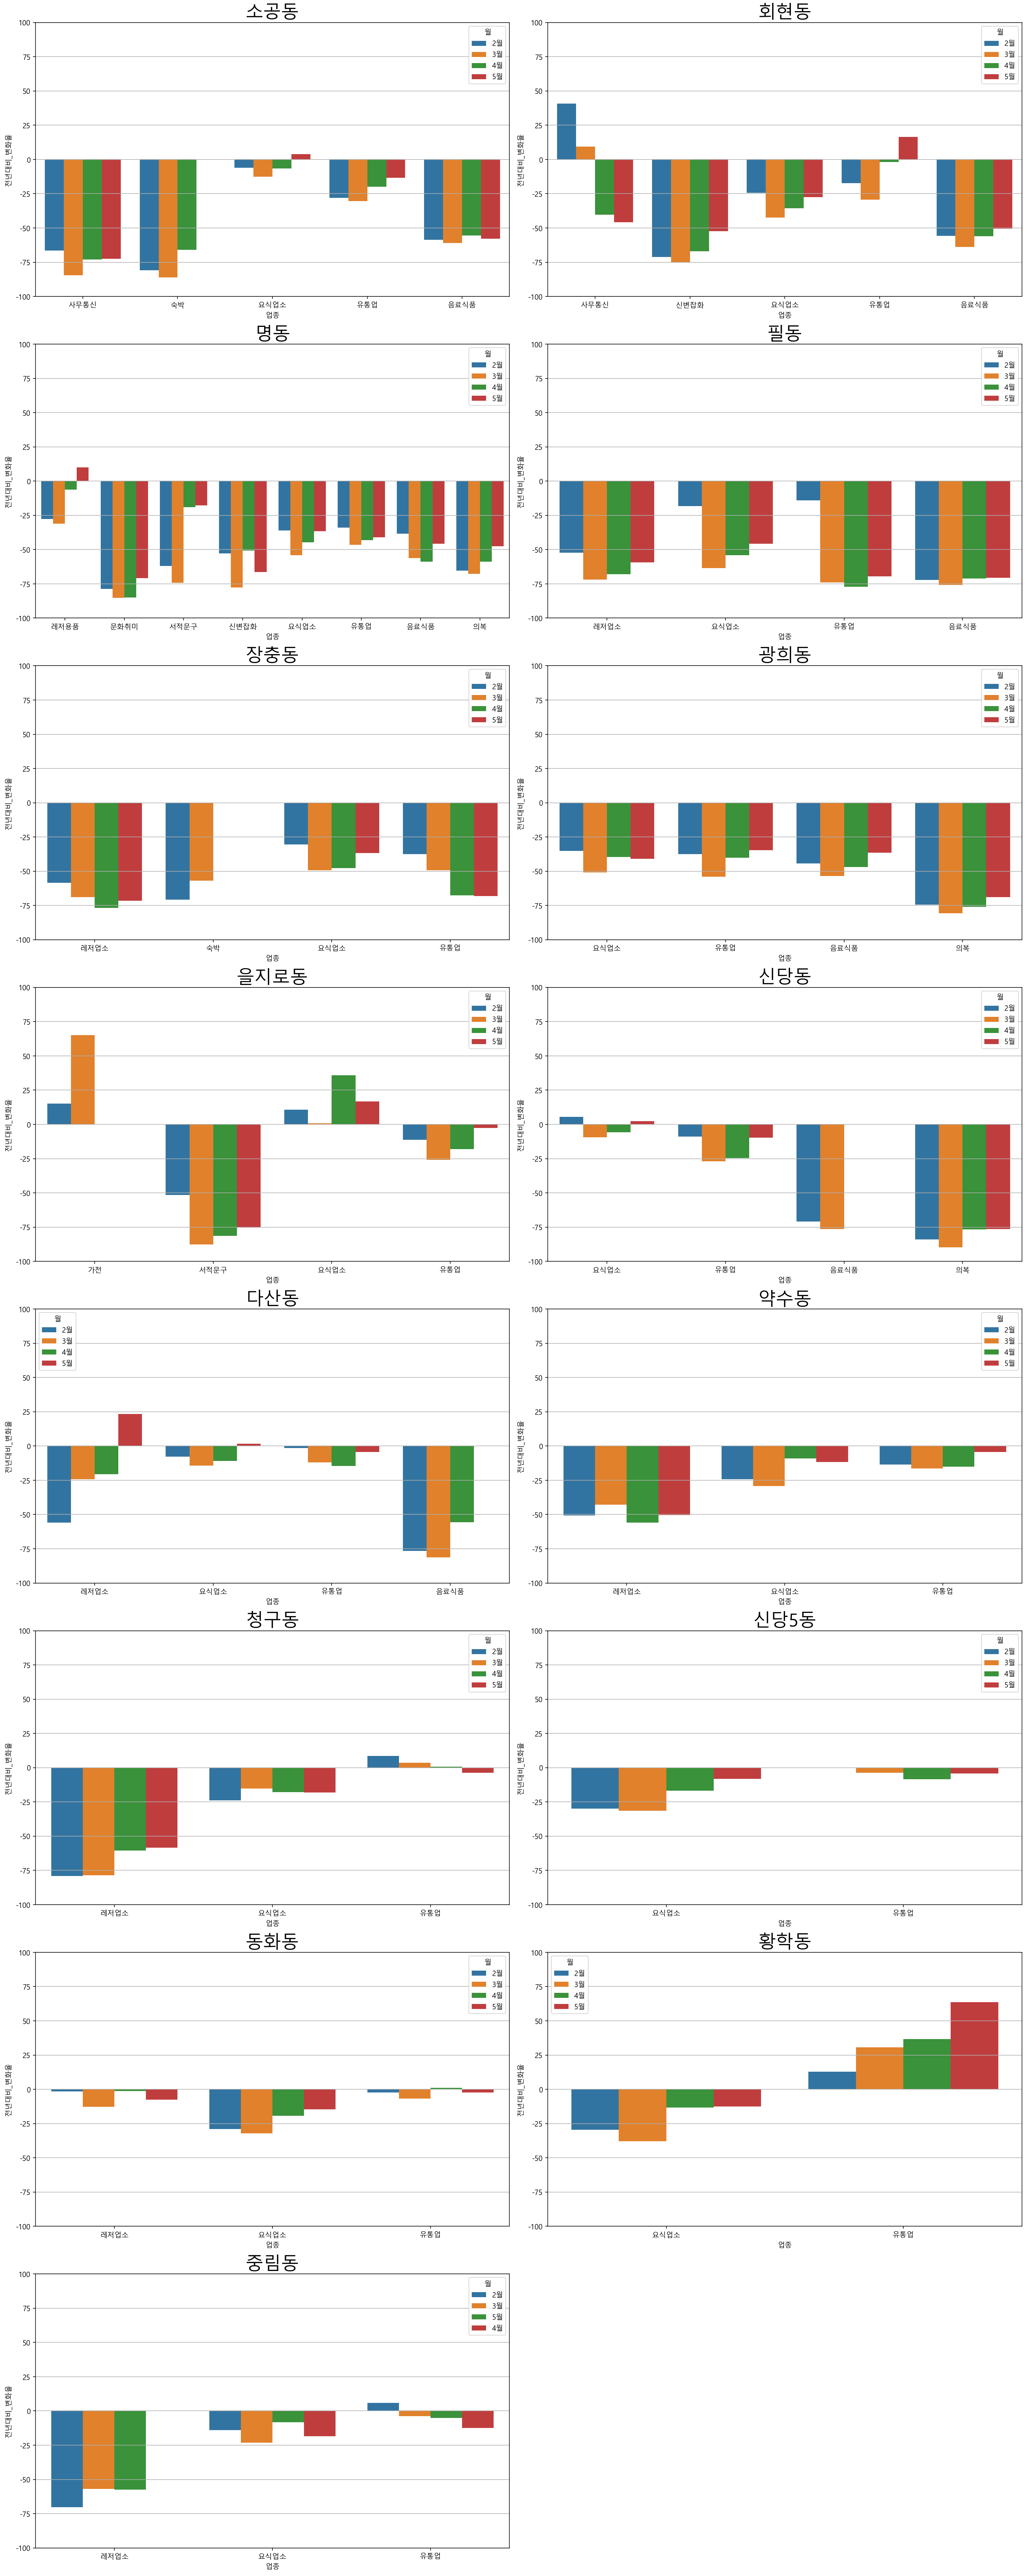

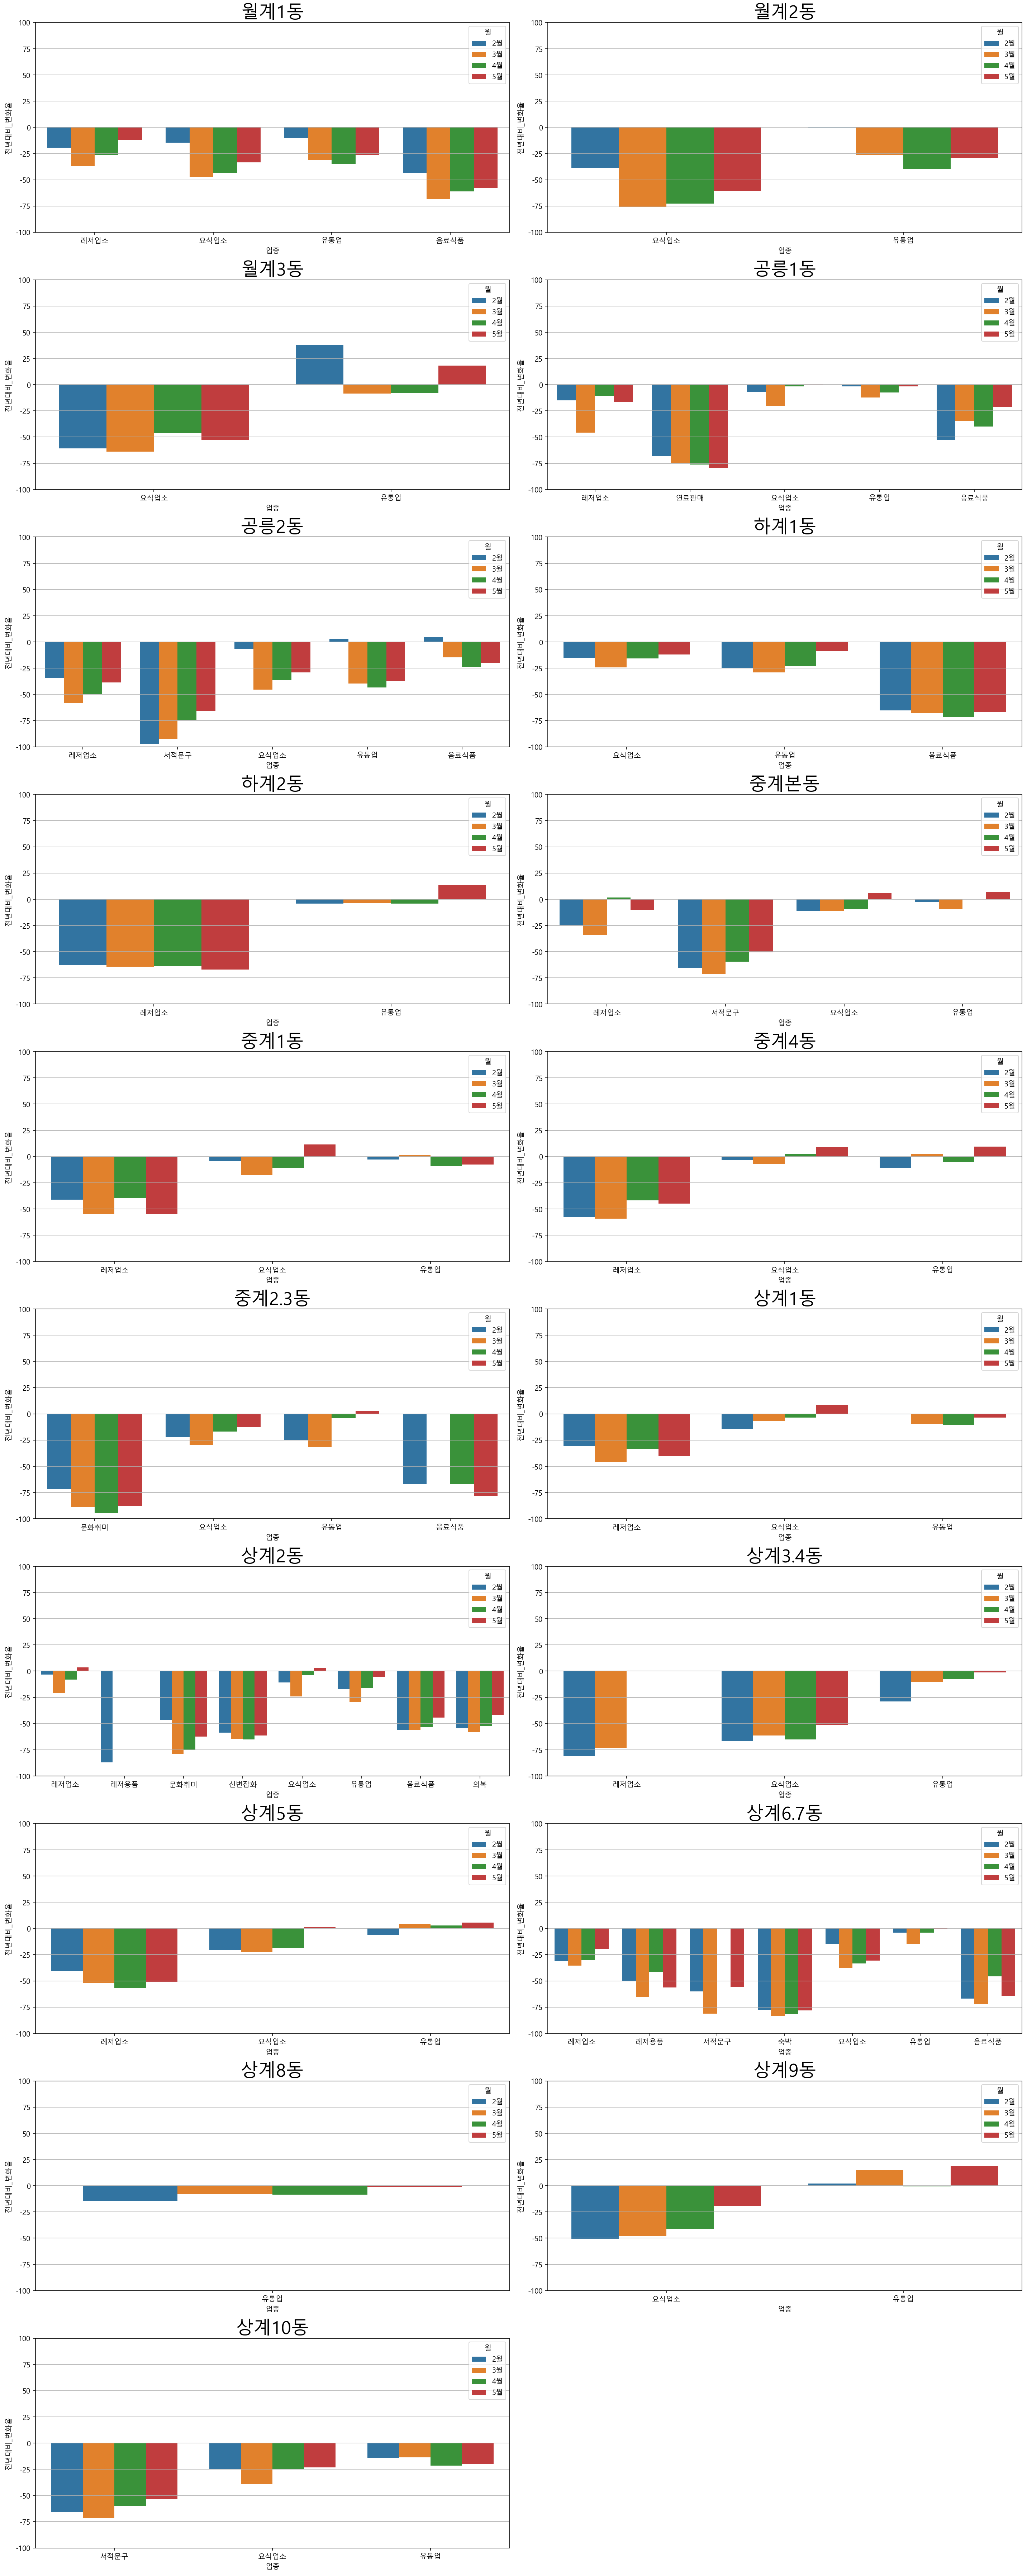

In [27]:
for gu in ['서울 중구','서울 노원구']:
    makefigure(gu)
    
#신한카드가 가계의 매출전체를 대변할 수는 없지만 경향성을 설명해줄수 있다

서울 노원구 공릉1동
                 이용건수    이용금액
Month 업종   Year              
2     레저업소 2019 187.5  1503.4
           2020 135.4  1278.5
      연료판매 2019 117.6  3377.4
           2020  33.3  1080.0
      요식업소 2019 505.5  9044.9
           2020 508.7  8420.0
      유통업  2019 749.7  4105.6
           2020 694.9  4043.2
      음료식품 2019 114.8  1033.9
           2020  47.8   489.7
3     레저업소 2019 174.6  1641.1
           2020 109.9   887.7
      연료판매 2019 126.4  4077.8
           2020  33.5  1025.6
      요식업소 2019 575.6 10088.8
           2020 518.9  8067.3
      유통업  2019 886.4  4637.1
           2020 687.9  4061.7
      음료식품 2019 125.4   889.9
           2020  53.8   579.9
4     레저업소 2019 166.5  1315.3
           2020  99.5  1171.1
      연료판매 2019 127.9  3744.7
           2020  31.8   894.2
      요식업소 2019 579.2  8986.7
           2020 577.2  8832.0
      유통업  2019 869.4  4410.1
           2020 715.4  4086.8
      음료식품 2019 118.8   935.1
           2020  56.6   560.5
5     레저업소 2019 181.9  1809.

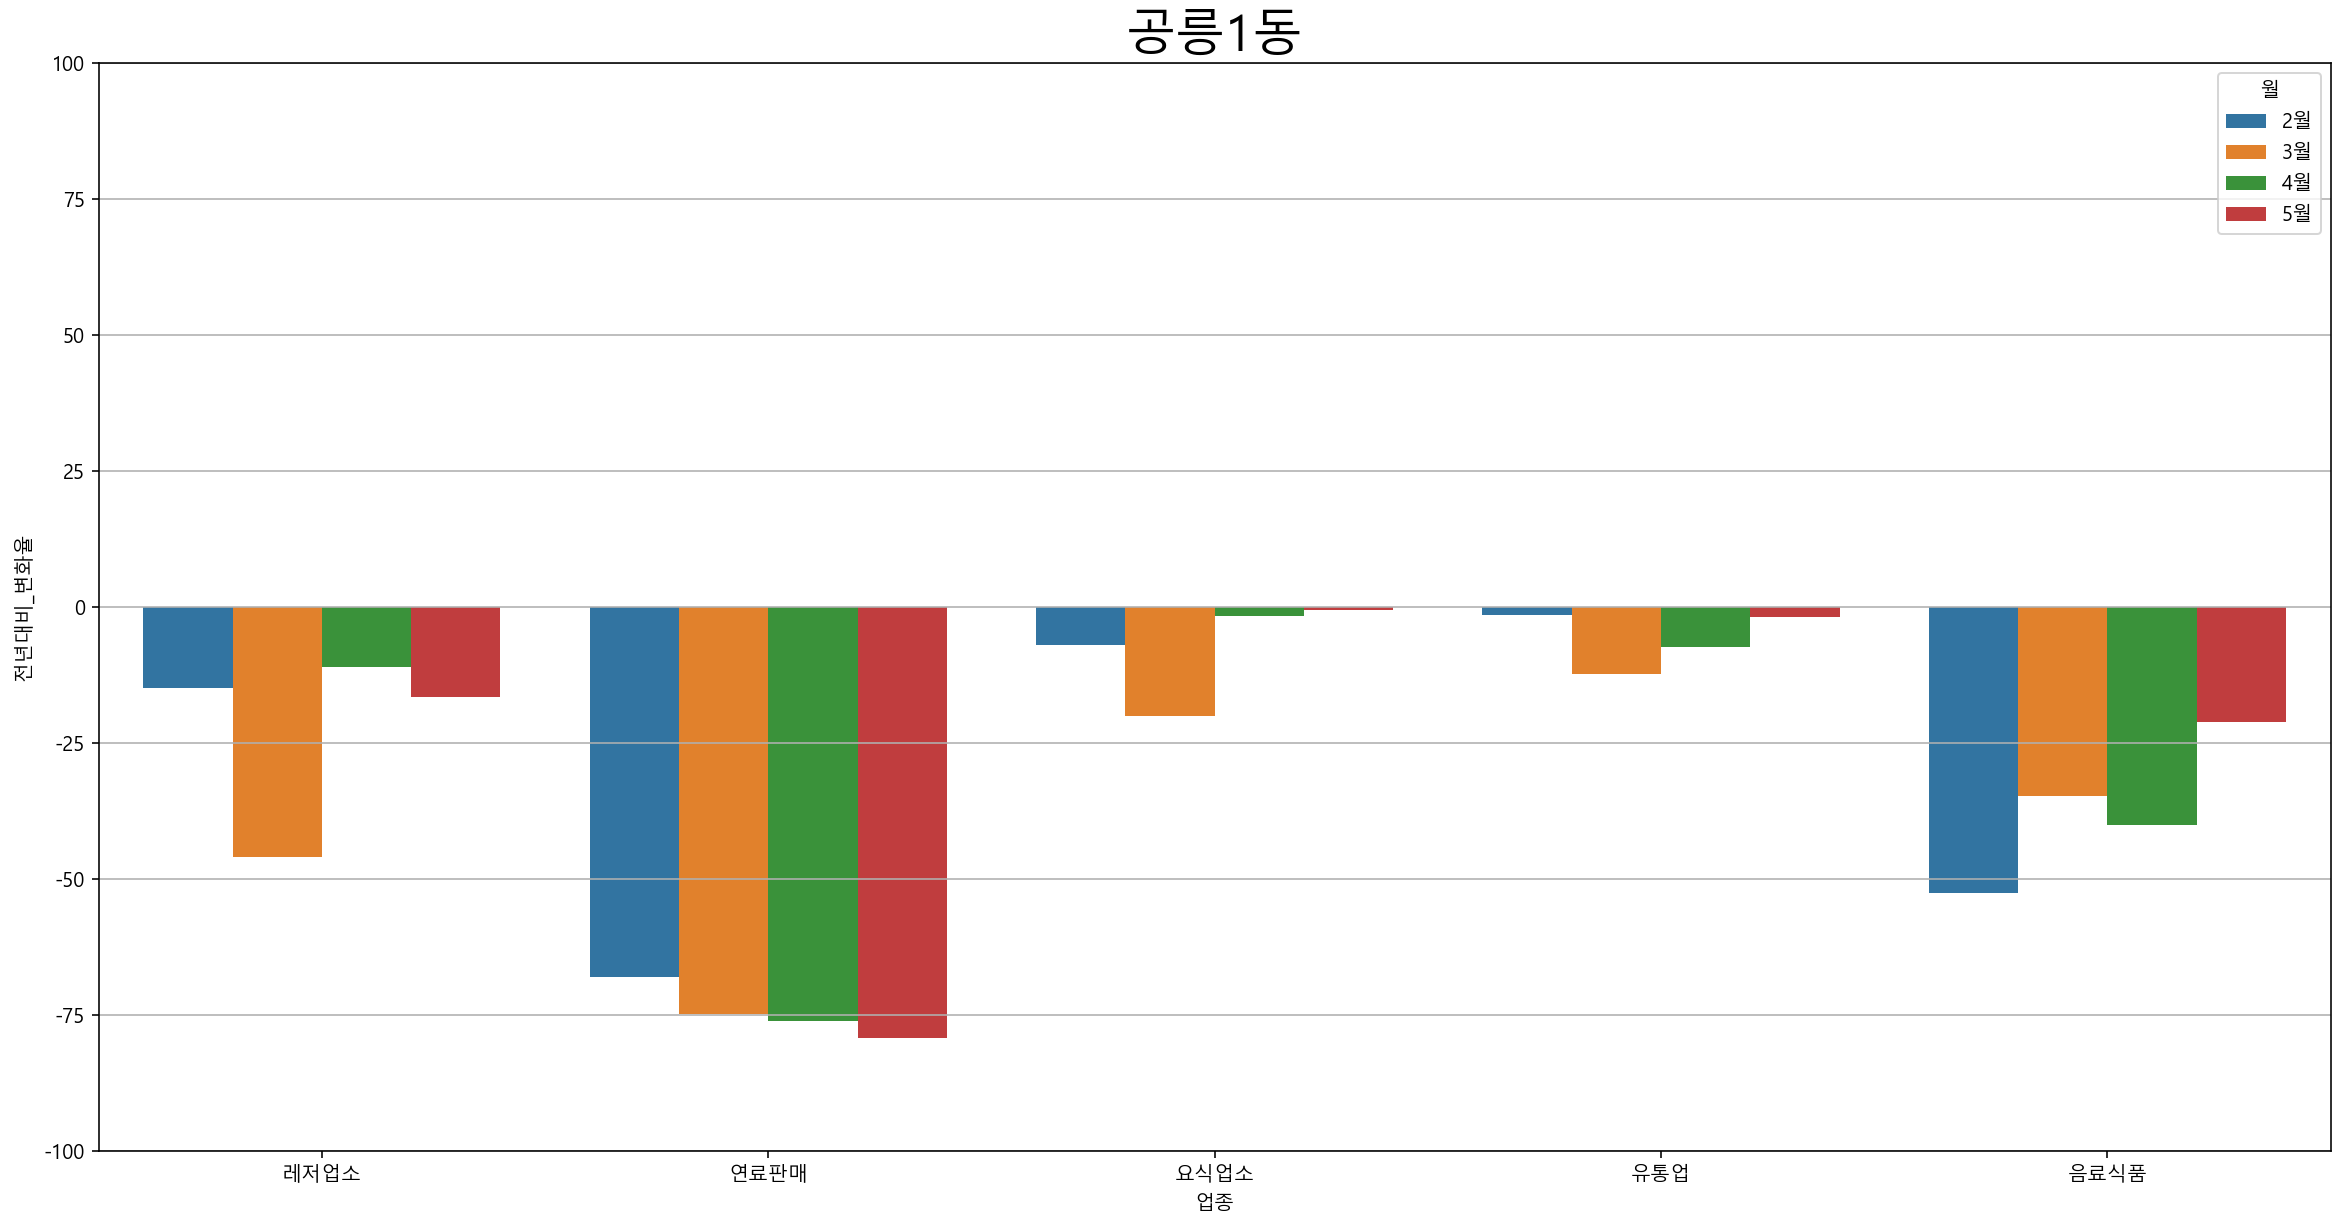

In [28]:
plt.rcParams['figure.figsize'] = [20,10]
gu_dong('서울 노원구','공릉1동')

In [29]:
df_new

NameError: name 'df_new' is not defined

# 노원구 중구의 코로나 이전(2019)과 이후(2020) 업종별 이용건수 이용금액 추이

In [ ]:

plt.rcParams['figure.figsize'] = [20,10]
g1 = sns.barplot(data = df_0.loc['서울 노원구'].reset_index(),x='업종', y='이용건수',hue='Year', ci=None)
plt.title('업종별 이용건수 변화\n', {'fontsize' : 25, 'color':'black'})
plt.plot

In [ ]:
g2 = sns.barplot(data = df_0.loc['서울 노원구'].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)
plt.title('업종별 이용금액 변화\n', {'fontsize' : 25, 'color':'black'})
plt.plot

In [ ]:
g3 = sns.barplot(data = df_1.loc['서울 노원구','상계6.7동'].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)

In [ ]:
g3 = sns.barplot(data = df_0.loc['서울 중구',5].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)

In [ ]:
df_set['동별'] = df_seoul[df_seoul['시_구']=='서울 중구'].groupby(['행정동','기준일자'],as_index=True).sum()[['이용건수','이용금액']]
df_set['업종별'] = df_seoul[df_seoul['시_구']=='서울 중구'].groupby(['업종','기준일자'],as_index=True).sum()[['이용건수','이용금액']]

---

In [ ]:
import pandas as pd
import pickle
df_corona = pd.read_csv('modeling/data/서울시 확진자 현황.csv', encoding='ANSI')

In [ ]:
df_corona.head()

In [36]:
df_corona['접촉력'].value_counts()[:30].to_csv('abcd.csv', encoding='cp949')

In [37]:
dfhan = pd.read_pickle('modeling/data/검색어트렌드_한양대_final.pkl')

In [38]:
dfhan

,date,한양대역,가락시장역,가산디지털단지역,강남역,강남구청역,강동역,강동구청역,강변역,개롱역,...,학여울역,한강진역,한성대입구역,합정역,행당역,혜화역,홍대입구역,홍제역,화곡역,화랑대역
0,2020-02-01,18.2,14.3,28.1,175.4,23.1,46.1,32.1,39.7,2.4,...,1.1,22.2,4.1,245.8,1.2,123.2,10.6,4.9,39.3,4.8
1,2020-02-02,18.4,13.7,27.6,180.0,22.7,48.5,31.2,39.7,2.4,...,1.1,24.1,4.2,250.4,1.2,128.5,11.1,4.9,39.3,5.3
2,2020-02-03,18.1,13.5,27.6,184.3,22.5,49.9,31.3,39.8,2.4,...,1.1,24.3,3.9,250.3,1.2,128.1,10.7,4.8,39.8,5.6
3,2020-02-04,18.4,13.2,28.3,188.3,22.8,48.4,31.8,38.2,2.3,...,1.2,23.5,3.8,245.5,1.1,125.5,10.6,4.8,37.7,5.6
4,2020-02-05,19.0,13.0,28.4,191.7,22.6,48.2,31.2,38.3,2.3,...,1.2,23.9,3.7,245.1,1.1,125.7,10.7,4.5,37.3,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2020-08-27,10.8,16.5,24.5,134.3,20.5,65.3,35.5,35.4,2.9,...,0.0,15.3,3.8,194.9,1.2,73.8,6.6,7.7,40.4,7.4
209,2020-08-28,10.1,17.3,24.8,141.1,21.0,70.2,36.9,37.6,2.3,...,0.0,16.0,4.1,208.4,1.2,79.1,6.8,8.2,43.1,8.8
210,2020-08-29,9.3,18.0,24.9,149.5,20.9,77.1,38.3,41.7,2.6,...,0.0,16.9,4.1,225.3,1.3,85.2,7.3,9.1,47.7,9.3
211,2020-08-30,8.4,18.5,23.2,155.0,19.8,86.7,40.2,44.0,2.0,...,0.0,17.3,4.0,231.0,1.1,86.8,7.7,9.9,51.6,11.2


서울시 확진자 중 감염경로라고 볼수 있는 접촉력에대해 보면 밀집된 장소에서 주로 감염이 되었다고 볼수있다.
-> 밀집된장소는 위험하다, 피해야한다

# 여기까지가 창윤쓰정리

아래는 내 skt정리

In [ ]:
#데이터 연결(성별나이)
age1902= pd.read_csv(r'./4개지역_FLOW_AGE_201902.CSV', sep = '|')
age1903= pd.read_csv(r'./4개지역_FLOW_AGE_201903.CSV', sep = '|')
age1904= pd.read_csv(r'./4개지역_FLOW_AGE_201904.CSV', sep = '|')
age1904= pd.read_csv(r'./4개지역_FLOW_AGE_201905.CSV', sep = '|')
age2002= pd.read_csv(r'./4개지역_FLOW_AGE_202002.CSV', sep = '|')
age2003= pd.read_csv(r'./4개지역_FLOW_AGE_202003.CSV', sep = '|')
age2004= pd.read_csv(r'./4개지역_FLOW_AGE_202004.CSV', sep = '|')
age2005= pd.read_csv(r'./4개지역_FLOW_AGE_202005.CSV', sep = '|')

In [ ]:
#데이터 연결(시간)
time1902= pd.read_csv(r'./4개지역_FLOW_TIME_201902.CSV', sep = '|')
time1903= pd.read_csv(r'./4개지역_FLOW_TIME_201903.CSV', sep = '|')
time1904= pd.read_csv(r'./4개지역_FLOW_TIME_201904.CSV', sep = '|')
time1905= pd.read_csv(r'./4개지역_FLOW_TIME_201905.CSV', sep = '|')
time2002= pd.read_csv(r'./4개지역_FLOW_TIME_202002.CSV', sep = '|')
time2003= pd.read_csv(r'./4개지역_FLOW_TIME_202003.CSV', sep = '|')
time2004= pd.read_csv(r'./4개지역_FLOW_TIME_202004.CSV', sep = '|')
time2005= pd.read_csv(r'./4개지역_FLOW_TIME_202005.CSV', sep = '|')

In [ ]:
# 4개 구에 대한 그래프 그리는 함수. 원하는 데이터프레임과 날짜넣으면 찾아서표시해줌  
def Drawing(df, day):
  df1= df[69*(day-1):69*(day-1)+15]
  df2= df[69*(day-1)+15:69*(day-1)+34]
  df3= df[69*(day-1)+34:69*(day-1)+46]
  df4= df[69*(day-1)+46:69*(day-1)+69]
  df_seoul = pd.concat([df1, df2])
  df_deagu = pd.concat([df3, df4])
  df_total = pd.concat([df_seoul, df_deagu])

  
  df1.iloc[:,4:].T.plot(figsize=(20,10))
  plt.legend(df1.iloc[:,3])
  plt.title("Seoul JungGu")
  plt.xlabel("Time")
  plt.ylabel("Number of Population")
  plt.grid()
  plt.show()

  df2.iloc[:,4:].T.plot(figsize=(20,10))
  plt.legend(df2.iloc[:,3])
  plt.title("Seoul NowonGu")
  plt.xlabel("Time")
  plt.ylabel("Number of Population")
  plt.grid()
  plt.show()

  df3.iloc[:,4:].T.plot(figsize=(20,10))
  plt.legend(df3.iloc[:,3])
  plt.title("Deagu JungGu")
  plt.xlabel("Time")
  plt.ylabel("Number of Population")
  plt.grid()
  plt.show()

  df4.iloc[:,4:].T.plot(figsize=(20,10))
  plt.legend(df4.iloc[:,3])
  plt.title("Deagu SusungGu")
  plt.xlabel("Time")
  plt.ylabel("Number of Population")
  plt.grid()
  plt.show()
  
  #서울전체 보고싶으면 아래코드 활성화
  # df_seoul.iloc[:,4:].T.plot(figsize=(20,10))
  # plt.legend(df_seoul.iloc[:,3])
  # plt.title("Seoul")
  # plt.xlabel("Time")
  # plt.ylabel("Number of Population")
  # plt.grid()
  # plt.show()
  
  #대구전체 보고싶으면 아래코드 활성화
  # df_deagu.iloc[:,4:].T.plot(figsize=(20,10))
  # plt.legend(df_deagu.iloc[:,3])
  # plt.title("Deagu")
  # plt.xlabel("Time")
  # plt.ylabel("Number of Population")
  # plt.grid()
  # plt.show()
  
  #전체 보고싶으면 아래코드 활성화
  # df_total.iloc[:,4:].T.plot(figsize=(20,10))
  # plt.legend(df_total.iloc[:,3])
  # plt.title("Total")
  # plt.xlabel("Time")
  # plt.ylabel("Number of Population")
  # plt.grid()
  # plt.show()

In [ ]:
Drawing(time2003, 8)
Drawing(time2003, 15)

In [ ]:
#구별로 합쳐서 볼 수 있는 함수
def TotalDrawing(df, day):
  time_col = df.columns
  
  df1= df[69*(day-1):69*(day-1)+15]
  df2= df[69*(day-1)+15:69*(day-1)+34]
  df3= df[69*(day-1)+34:69*(day-1)+46]
  df4= df[69*(day-1)+46:69*(day-1)+69]

  timepop1=[]
  for i in time_col[4:]:
    timepop1.append(df1[i].sum())

  timepop2=[]
  for i in time_col[4:]:
    timepop2.append(df2[i].sum())

  timepop3=[]
  for i in time_col[4:]:
    timepop3.append(df3[i].sum())

  timepop4=[]
  for i in time_col[4:]:
    timepop4.append(df4[i].sum())

  total_df = pd.DataFrame({'Seoul JungGu' : timepop1,  'Seoul NowonGu' : timepop2, 'Deagu JungGu' : timepop3, 'Daegu SusungGu' : timepop4})

  total_df.plot(figsize=(20,10))
  plt.legend(total_df)
  plt.title("Total")
  plt.xlabel("Time")
  plt.ylabel("Number of Population")
  plt.grid()
  plt.show()

In [ ]:
TotalDrawing(time1902, 2)

여기까지가 일단 시각화

아래는 수범형?창윤?

In [ ]:
import os
import pandas as pd
from dbfread import DBF
from folium import plugins
import folium
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
# !pip install folium

In [ ]:
#아래에 유동인구가 있는 파일이 있는 경로 변경 필수
os.chdir(r'C:\Users\DOYEON\CONTEST\01. Big_contest\-DATA\01_유동인구데이터(SK텔레콤)')
path = os.getcwd()

# 유동인구 데이터
file_list = os.listdir(path)
file_list_csv = [file for file in file_list if file.endswith('.CSV')]
flow_age = file_list_csv[:8]

list_ = []

for files in flow_age:
    df = pd.read_csv(files,sep='|')
    list_.append(df)
flow_age = pd.concat(list_, ignore_index=True)

# 행정도DB 좌표 파일
dbf = DBF('4개지역_행정동(db파일).DBF')
dbf = pd.DataFrame(dbf)
dbf_ = dbf[['HDONG_CD','X_COORD','Y_COORD']]
dbf_['X_COORD'] = dbf_['X_COORD'].astype(float)
dbf_['Y_COORD'] = dbf_['Y_COORD'].astype(float)

dbf_['HDONG_CD'] = dbf_['HDONG_CD'].astype(str)
flow_age['HDONG_CD'] = flow_age['HDONG_CD'].astype(str)

col = flow_age.columns
male_col,female_col  = col[4:19],col[19:]

for idx, (a, b) in enumerate(zip(male_col, female_col)):
 flow_age[idx] = flow_age[a] + flow_age[b]

In [ ]:
def float_pop_map(age,date1,date2, place):
    flow = flow_age[['STD_YM', 'HDONG_CD', 'HDONG_NM', age]]
    flow_mm = flow.groupby(['STD_YM','HDONG_CD']).sum().reset_index()
    flow_mm1 = flow_mm[flow_mm['STD_YM']== date1]
    flow_mm2 = flow_mm[flow_mm['STD_YM']== date2]
    
    flow_mm1, flow_mm2 = flow_mm1.merge(dbf_,on='HDONG_CD'),flow_mm2.merge(dbf_,on='HDONG_CD')

    m = folium.plugins.DualMap(
        location = place[0],
        zoom_start = 12
    )
    for i in flow_mm1.index:
        marker = folium.CircleMarker([flow_mm1['Y_COORD'].iloc[i],flow_mm1['X_COORD'].iloc[i]],
                                    radius = flow_mm1[age].iloc[i]/10000,
                                    color='#3186cc')
        marker.add_to(m.m1)

        marker = folium.CircleMarker([flow_mm2['Y_COORD'].iloc[i],flow_mm2['X_COORD'].iloc[i]],
                                    radius = flow_mm2[age].iloc[i]/10000,
                                    color='red')
        marker.add_to(m.m2)
    return m

In [ ]:
age = 14#0부터 14까지 있고, 0-4, 5-9형태임
date1 = 201905 #월만 변경하기
date2 = 202005
place = [[37.6036, 127.0500]]
place_ = [[35.8417, 128.6322]]

In [ ]:
# 서울
float_pop_map(age,date1,date2,place)

In [ ]:
# 대구
float_pop_map(age,date1,date2,place_ )

In [ ]:
col = flow_age.columns
male_col,female_col  = col[4:19],col[19:]

male_age_col,female_age_col = [], []
for i in range(8):
    male_age_col.append('male_age_{:02}'.format(i*10))
    female_age_col.append('female_age_{:02}'.format(i*10))
    
# 나이대별 합치기 ex.1014 + 1519 -> 10대
for idx, i in enumerate(range(0,15,2)):
    if idx == 7:
        flow_age[male_age_col[idx]] = flow_age[male_col[i]]
        flow_age[female_age_col[idx]] = flow_age[female_col[i]]
    else:
        flow_age[male_age_col[idx]] = flow_age[male_col[i]] + flow_age[male_col[i+1]]
        flow_age[female_age_col[idx]] = flow_age[female_col[i]] + flow_age[female_col[i+1]]

In [ ]:
# 월별로 sum()
flow_age_mm = flow_age[['STD_YM','male_age_00', 'female_age_00', 'male_age_10',
       'female_age_10', 'male_age_20', 'female_age_20', 'male_age_30',
       'female_age_30', 'male_age_40', 'female_age_40', 'male_age_50',
       'female_age_50', 'male_age_60', 'female_age_60', 'male_age_70',
       'female_age_70']]
flow_age_mm_ = flow_age_mm.groupby('STD_YM').sum().reset_index()
month = ['Month_{:02}'.format(i) for i in range(2,6)]

In [ ]:
flow_age.sort_values(by=['STD_YM'],axis=0)

In [ ]:
dict_age = {'female':[],'male':[],'female_2019':[],'male_2019':[],'female_2020':[],'male_2020':[]}
for i in range(8):
    dict_age['female_2019'].append(round(flow_age['female_age_{:02}'.format(i*10)][:8280].sum()))
    dict_age['male_2019'].append(round(flow_age['male_age_{:02}'.format(i*10)][:8280].sum()))
    dict_age['female_2020'].append(round(flow_age['female_age_{:02}'.format(i*10)][8280:].sum()))
    dict_age['male_2020'].append(round(flow_age['male_age_{:02}'.format(i*10)][8280:].sum()))
    dict_age['female'].append(round(flow_age['female_age_{:02}'.format(i*10)].sum()))
    dict_age['male'].append(round(flow_age['male_age_{:02}'.format(i*10)].sum()))
    
age_dist = pd.DataFrame(dict_age)
age_dist.index = ['00대','10대','20대','30대','40대','50대','60대','70U']
age_dist.columns

In [ ]:
age_dist[['female', 'male']].plot(kind='bar')
plt.title('전체 나이대별 유동인구 분포')

age_dist[['female_2019', 'male_2019']].plot(kind='bar')
plt.title('2019년나이대별 유동인구 분포')

age_dist[['female_2020', 'male_2020']].plot(kind='bar')
plt.title('2020년나이대별 유동인구 분포')

In [ ]:
for i in range(8):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
    ax1.plot(month, flow_age_mm_['male_age_{:02}'.format(i*10)][:4], color="blue", label="2019")
    ax1.plot(month, flow_age_mm_['male_age_{:02}'.format(i*10)][4:], color="red", label="2020")
    ax1.legend(loc="lower right", title="Legend Title", frameon=False)
    ax1.set_title('Male_{:02}'.format(i*10))


    ax2.plot(month, flow_age_mm_['female_age_{:02}'.format(i*10)][:4], color="blue", label="2019")
    ax2.plot(month, flow_age_mm_['female_age_{:02}'.format(i*10)][4:], color="red", label="2020")
    ax2.legend(loc="lower right", title="Legend Title", frameon=False)
    ax2.set_title('Female_{:02}'.format(i*10))
    plt.show()

In [ ]:
flow_age_mm_.columns

여기까지가 도연

In [ ]:
age1902= pd.read_csv(r'C:\Users\sb\TIL\TIL\01_유동인구데이터(SK텔레콤)\4개지역_FLOW_AGE_201902.CSV', sep = '|')
age1903= pd.read_csv(r'C:\Users\sb\TIL\TIL\01_유동인구데이터(SK텔레콤)\4개지역_FLOW_AGE_201903.CSV', sep = '|')
age1904= pd.read_csv(r'C:\Users\sb\TIL\TIL\01_유동인구데이터(SK텔레콤)\4개지역_FLOW_AGE_201904.CSV', sep = '|')
age1905= pd.read_csv(r'C:\Users\sb\TIL\TIL\01_유동인구데이터(SK텔레콤)\4개지역_FLOW_AGE_201905.CSV', sep = '|')
age2002= pd.read_csv(r'C:\Users\sb\TIL\TIL\01_유동인구데이터(SK텔레콤)\4개지역_FLOW_AGE_202002.CSV', sep = '|')
age2003= pd.read_csv(r'C:\Users\sb\TIL\TIL\01_유동인구데이터(SK텔레콤)\4개지역_FLOW_AGE_202003.CSV', sep = '|')
age2004= pd.read_csv(r'C:\Users\sb\TIL\TIL\01_유동인구데이터(SK텔레콤)\4개지역_FLOW_AGE_202004.CSV', sep = '|')
age2005= pd.read_csv(r'C:\Users\sb\TIL\TIL\01_유동인구데이터(SK텔레콤)\4개지역_FLOW_AGE_202005.CSV', sep = '|')